In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import missingno as msno
import seaborn as sns
import scipy as sc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn import manifold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import decomposition
from sklearn.cluster import KMeans, DBSCAN

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (silhouette_score, adjusted_rand_score)


from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.externals import joblib


# Apprentissage supervisé 

L'objectif de ce notebook est de prédire l'appartenance d'un utilisateur à un cluster et d'étudier la qualité de cette prédiction en fonction de différents scénarii comme le nombre de commandes préalablement effectuées par les utilisateurs testés ou encore en entrainant sur certains mois et en prédisant sur les mois suivants. Pour cela, on effectue une classification supervisée en utilisant les labels de notre "carte" de clusters non supervisée. 

On évalue notre modèle sur le jeu de test dans lequel on détermine les labels via un k_nn appliquée sur la carte des clusters générée via le jeu d'entrainement.



In [112]:

# ouvrir les données 

df_test = pd.read_csv('df_test.csv')
df_test.loc[:,'InvoiceDate'] = pd.to_datetime(df_test.InvoiceDate,errors='coerce')


# ouvrir les données 

df_train = pd.read_csv('df_train.csv')
df_train.loc[:,'InvoiceDate'] = pd.to_datetime(df_train.InvoiceDate,errors='coerce')




In [121]:
def delete_t_value(df,t):
    """garde les t premières commandes dans le temps"""
    
    valeurs_cust_trans = shuffle(plot_value_counts('CustomerID',df=df))  
    
    ind_date = df.columns.get_loc('InvoiceDate')
        
    df_work = df.copy()      
            
    for i in range (valeurs_cust_trans.shape[0]):
        if (valeurs_cust_trans.iloc[i,0] != 0):
            df_trans = df[df.loc[:,'CustomerID'] == valeurs_cust_trans.iloc[i,0]] 
            val_transaction = plot_value_counts('InvoiceNo',df=df_trans)

            # associer la date
            vect = np.zeros(val_transaction.shape[0])
            val_transaction['date'] = vect[:]

            for j in range (val_transaction.shape[0]):            

                df_trans_date = df_trans[df_trans.loc[:,'InvoiceNo'] == val_transaction.iloc[j,0]]
                val_transaction.iloc[j,3] = df_trans_date.iloc[0,ind_date]      

            # trier les jeux de données 
            val_transaction = val_transaction.sort_values(by=['date'], ascending=True)


            # ne garder que les t premières transactions  
            if (val_transaction.shape[0] < t):
                val_transaction.loc[:,'InvoiceNo'] = 'Nan'

            val_transaction = val_transaction.iloc[0:t,:]    


            df_work_final = df_work[(df_work.loc[:,'InvoiceNo'].isin(val_transaction.loc[:,'InvoiceNo']))].reset_index(drop=True)
            if (i == 0):
                result = df_work_final
            else :
                result = pd.concat([result, df_work_final], axis=0)      
        
           
    return (result)

In [4]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    #print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

In [5]:
# modèle sans les mois mais en considérant tous les utilisateurs 

def features(df,t):
    """enregiste les features associées aux utilisateurs (utilisé pour l'entrée de l'algorithme
    de classification)"""
    
    valeurs_items = pd.read_csv('valeurs_items.csv')
    
    ind_date = df.columns.get_loc('InvoiceDate')
    df['DAY'] = df.iloc[:,ind_date].dt.weekday    
    df['MONTH'] = df.iloc[:,ind_date].dt.month    
    df['HOUR'] = df.iloc[:,ind_date].dt.hour
    
    
    # repérer les indices
    ind_h = df.columns.get_loc('HOUR')
    ind_m = df.columns.get_loc('MONTH')
    ind_m = df.columns.get_loc('DAY')
    ind_price = df.columns.get_loc('UnitPrice')
    ind_cust = df.columns.get_loc('CustomerID')
    ind_q = df.columns.get_loc('Quantity')
    
    ind_cbis = df.columns.get_loc('Country_bis')

    valeurs_cust = plot_value_counts('CustomerID',df=df)    
      
    
    valeurs_month = plot_value_counts('MONTH',df=df)
    valeurs_month.iloc[:,0] = pd.to_numeric(valeurs_month.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
    
    
    
    # ---------------------------------------- Associer les caractéristiques moyennes ------------------------------------

    #définir un vecteur numpy
    vect = np.zeros(valeurs_cust.shape[0])
    dataset_clust = valeurs_cust.iloc[:,[0]]

    #ajouter les nouvelles caractéristiques
    #dataset_clust['lasttransaction'] = vect[:]
    dataset_clust['nb_unit'] = vect[:]
    dataset_clust['prix_unit'] = vect[:]
    dataset_clust['montant'] = vect[:]
    dataset_clust['pays'] = vect[:]
    dataset_clust['nb_produit_diff'] = vect[:]
    dataset_clust['nb_commandes'] = vect[:]
    if (t>0):
        dataset_clust['nb_produit_id'] = vect[:]        
        dataset_clust['frequence'] = vect[:]
    
    
    # tenir compte du jour de la semaine et de l'heure des transactions par 4 nouvelles variables
    # le jour(heure) comptant le plus grand nombre de transaction (0 à 7) et la probabilité de transaction 
    # ce jour(heure) ie le ratio nombre de transaction enregistrées le jour du maximum de transaction sur le nombre total
    # de transactions
    dataset_clust['jourmax'] = vect[:]
    dataset_clust['heuremax'] = vect[:]
    dataset_clust['jourprob'] = vect[:]
    dataset_clust['heureprob'] = vect[:]

    # associer la valeur 1 lorsque le pays est uk et 0 sinon
    df['Country_bis'][df.loc[:,'Country_bis'] == 'UK'] = 1
    df['Country_bis'][df.loc[:,'Country_bis'] == 'Foreign'] = 0
    
    # ------------------------- popularité ---------------------------------------------    
    # on rajoute une nouvelle variable inspirée du modèle collaboratif "la popularité"
    dataset_clust['pop1'] = vect[:]
    dataset_clust['pop2'] = vect[:]
    
    valeurs_items = plot_value_counts('StockCode',df=df)
    vect = np.zeros(valeurs_items.shape[0])
    valeurs_items['pop1'] = vect[:]
    valeurs_items['pop2'] = vect[:]
    
    #----------------------------------------------------------------------------------


    # remplir les colonnes 
    for i in range (dataset_clust.shape[0]):
        
        df_trans =  df[df.iloc[:,ind_cust] == valeurs_cust.iloc[i,0]] 
        
        dataset_clust.loc[i,'nb_unit'] = np.mean(df_trans.iloc[:,ind_q])
        dataset_clust.loc[i,'prix_unit'] = np.mean(df_trans.iloc[:,ind_price])
        dataset_clust.loc[i,'montant'] = np.mean(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))
        dataset_clust.loc[i,'pays'] = df_trans.iloc[0,ind_cbis]
        
        if (t>0):    
            dataset_clust.loc[i,'frequence'] = (np.amax(df_trans.loc[:,'InvoiceDate']) - 
                                                    np.amin(df_trans.loc[:,'InvoiceDate']))/df_trans.shape[0]

            # convertir le temps en seconde      
            dataset_clust.loc[i,'frequence'] = dataset_clust.loc[i,'frequence'].total_seconds()
            dataset_clust.loc[i,'frequence'] = float(dataset_clust.loc[i,'frequence'])
        
        
        #dataset_clust.loc[i,'lasttransaction'] = (np.amax(df.loc[:,'InvoiceDate']) - 
                                        #    np.amax(df_trans.loc[:,'InvoiceDate']))
            
         # convertir le temps en seconde        
        #dataset_clust.loc[i,'lasttransaction'] = dataset_clust.loc[i,'lasttransaction'].total_seconds()
        #dataset_clust.loc[i,'lasttransaction'] = float(dataset_clust.loc[i,'lasttransaction'])        
       
        
        valeurs_day = plot_value_counts('DAY',df=df_trans)
        valeurs_day.iloc[:,0] = pd.to_numeric(valeurs_day.iloc[:,0], errors='coerce').fillna(0, downcast='infer')       
        dataset_clust.loc[i,'jourmax'] = valeurs_day.iloc[0,0]
        dataset_clust.loc[i,'jourprob'] = valeurs_day.iloc[0,1]/np.sum(valeurs_day.iloc[0,:])
        
        valeurs_hour = plot_value_counts('HOUR',df=df_trans)
        valeurs_hour.iloc[:,0] = pd.to_numeric(valeurs_hour.iloc[:,0], errors='coerce').fillna(0, downcast='infer')            
        dataset_clust.loc[i,'heuremax'] = valeurs_hour.iloc[0,0]    
        dataset_clust.loc[i,'heureprob'] = valeurs_hour.iloc[0,1]/np.sum(valeurs_hour.iloc[0,:])
        
        
        valeurs_invoice = plot_value_counts('InvoiceNo',df=df_trans)
        dataset_clust.loc[i,'nb_produit_diff'] = np.mean(valeurs_invoice.iloc[:,1])
        dataset_clust.loc[i,'nb_commandes'] = valeurs_invoice.shape[0]
        
        valeurs_identiques = plot_value_counts('StockCode',df=df_trans)
        if (t>0):
            dataset_clust.loc[i,'nb_produit_id'] = np.mean(valeurs_identiques.iloc[:,1]) 
        
        # popularité 
        # considérer les items communs entre valeurs_items et valeurs_identiques
        valeurs_pop = valeurs_items[(valeurs_items.loc[:,'StockCode'].isin(valeurs_identiques.iloc[:,0]))].reset_index(drop=True)
        # le score de popularité utilisateur est la moyenne des scores items 
        dataset_clust.loc[i,'pop1'] = np.mean(valeurs_pop.loc[:,'pop1'])
        dataset_clust.loc[i,'pop2'] = np.mean(valeurs_pop.loc[:,'pop2'])    
     
    
    return (dataset_clust)

In [6]:
def features_knn(df,ind):
    
    ind_date = df.columns.get_loc('InvoiceDate')
    
    df['DAY'] = df.iloc[:,ind_date].dt.weekday    
    df['MONTH'] = df.iloc[:,ind_date].dt.month    
    df['HOUR'] = df.iloc[:,ind_date].dt.hour
    
    
    # repérer les indices
    ind_h = df.columns.get_loc('HOUR')
    ind_m = df.columns.get_loc('MONTH')
    ind_m = df.columns.get_loc('DAY')
    ind_price = df.columns.get_loc('UnitPrice')
    ind_cust = df.columns.get_loc('CustomerID')
    ind_q = df.columns.get_loc('Quantity')
    
    ind_cbis = df.columns.get_loc('Country_bis')

    valeurs_cust = plot_value_counts('CustomerID',df=df)    
      
    
    valeurs_month = plot_value_counts('MONTH',df=df)
    valeurs_month.iloc[:,0] = pd.to_numeric(valeurs_month.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
    
    
    
    # ---------------------------------------- Associer les caractéristiques moyennes ------------------------------------

    #définir un vecteur numpy
    vect = np.zeros(valeurs_cust.shape[0])
    dataset_clust = valeurs_cust.iloc[:,[0]]

    #ajouter les nouvelles caractéristiques
    dataset_clust['lasttransaction'] = vect[:]
    dataset_clust['nb_unit'] = vect[:]
    dataset_clust['prix_unit'] = vect[:]
    dataset_clust['montant'] = vect[:]
    dataset_clust['pays'] = vect[:]
    dataset_clust['nb_produit_diff'] = vect[:]
    dataset_clust['nb_produit_id'] = vect[:]       
    dataset_clust['frequence'] = vect[:]
    
    
    # tenir compte du jour de la semaine et de l'heure des transactions par 4 nouvelles variables
    # le jour(heure) comptant le plus grand nombre de transaction (0 à 7) et la probabilité de transaction 
    # ce jour(heure) ie le ratio nombre de transaction enregistrées le jour du maximum de transaction sur le nombre total
    # de transactions
    dataset_clust['jourmax'] = vect[:]
    dataset_clust['heuremax'] = vect[:]
    dataset_clust['jourprob'] = vect[:]
    dataset_clust['heureprob'] = vect[:]

    # associer la valeur 1 lorsque le pays est uk et 0 sinon
    df['Country_bis'][df.loc[:,'Country_bis'] == 'UK'] = 1
    df['Country_bis'][df.loc[:,'Country_bis'] == 'Foreign'] = 0
    
    # ------------------------- popularité ---------------------------------------------    
    # on rajoute une nouvelle variable inspirée du modèle collaboratif "la popularité"
    dataset_clust['pop1'] = vect[:]
    dataset_clust['pop2'] = vect[:]
    
    if (ind == 0):
    
        valeurs_items = plot_value_counts('StockCode',df=df)
        vect = np.zeros(valeurs_items.shape[0])
        valeurs_items['pop1'] = vect[:]
        valeurs_items['pop2'] = vect[:]

        # on associe à chaque item deux indicateur de popularité 
        for i in range (valeurs_items.shape[0]):
            df_trans = df[df.loc[:,'StockCode'] == valeurs_items.iloc[i,0]]
            valeurs_items.iloc[i,3] = df_trans.shape[0]/df.shape[0]
            valeurs_items.iloc[i,4] = (np.sum(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))/
                                      (np.sum(df.iloc[:,ind_price].multiply(df.iloc[:,ind_q]))))    
        #----------------------------------------------------------------------------------
    if (ind == 1):
        
        valeurs_items = pd.read_csv('valeurs_items.csv')


    # remplir les colonnes 
    for i in range (dataset_clust.shape[0]):
        
        df_trans =  df[df.iloc[:,ind_cust] == valeurs_cust.iloc[i,0]] 
        
        dataset_clust.loc[i,'nb_unit'] = np.mean(df_trans.iloc[:,ind_q])
        dataset_clust.loc[i,'prix_unit'] = np.mean(df_trans.iloc[:,ind_price])
        dataset_clust.loc[i,'montant'] = np.mean(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))
        dataset_clust.loc[i,'pays'] = df_trans.iloc[0,ind_cbis]
        dataset_clust.loc[i,'frequence'] = (np.amax(df_trans.loc[:,'InvoiceDate']) - 
                                            np.amin(df_trans.loc[:,'InvoiceDate']))/df_trans.shape[0]
        
        # convertir le temps en seconde      
        dataset_clust.loc[i,'frequence'] = dataset_clust.loc[i,'frequence'].total_seconds()
        dataset_clust.loc[i,'frequence'] = float(dataset_clust.loc[i,'frequence'])
        
        
        dataset_clust.loc[i,'lasttransaction'] = (np.amax(df.loc[:,'InvoiceDate']) - 
                                            np.amax(df_trans.loc[:,'InvoiceDate']))
            
         # convertir le temps en seconde        
        dataset_clust.loc[i,'lasttransaction'] = dataset_clust.loc[i,'lasttransaction'].total_seconds()
        dataset_clust.loc[i,'lasttransaction'] = float(dataset_clust.loc[i,'lasttransaction'])        
       
        
        valeurs_day = plot_value_counts('DAY',df=df_trans)
        valeurs_day.iloc[:,0] = pd.to_numeric(valeurs_day.iloc[:,0], errors='coerce').fillna(0, downcast='infer')       
        dataset_clust.loc[i,'jourmax'] = valeurs_day.iloc[0,0]
        dataset_clust.loc[i,'jourprob'] = valeurs_day.iloc[0,1]/np.sum(valeurs_day.iloc[0,:])
        
        valeurs_hour = plot_value_counts('HOUR',df=df_trans)
        valeurs_hour.iloc[:,0] = pd.to_numeric(valeurs_hour.iloc[:,0], errors='coerce').fillna(0, downcast='infer')            
        dataset_clust.loc[i,'heuremax'] = valeurs_hour.iloc[0,0]    
        dataset_clust.loc[i,'heureprob'] = valeurs_hour.iloc[0,1]/np.sum(valeurs_hour.iloc[0,:])
        
        valeurs_invoice = plot_value_counts('InvoiceNo',df=df_trans)
        dataset_clust.loc[i,'nb_produit_diff'] = np.mean(valeurs_invoice.iloc[:,1])
        valeurs_identiques = plot_value_counts('StockCode',df=df_trans)
        dataset_clust.loc[i,'nb_produit_id'] = np.mean(valeurs_identiques.iloc[:,1]) 
        
        # popularité 
        # considérer les items communs entre valeurs_items et valeurs_identiques
        valeurs_pop = valeurs_items[(valeurs_items.loc[:,'StockCode'].isin(valeurs_identiques.iloc[:,0]))].reset_index(drop=True)
        # le score de popularité utilisateur est la moyenne des scores items 
        dataset_clust.loc[i,'pop1'] = np.mean(valeurs_pop.loc[:,'pop1'])
        dataset_clust.loc[i,'pop2'] = np.mean(valeurs_pop.loc[:,'pop2'])
    
     
    
    return (dataset_clust)

In [7]:
def accuracy(label_true,label_predict,clusters):
    """ calcule la matrice de confusion """
    

    # créer un dictionnaire 
    
    d = {'label_true':label_true.tolist(),'label_predict':label_predict.tolist()
        }
    label = pd.DataFrame(data=d)    
    
    vp = []
    fp = []
    vn = []
    fn = []
    dim = []
        
    for i in range (clusters): 
        size = label[label.loc[:,'label_true'] == i].shape[0]
        
        vp.append(label[(label.loc[:,'label_true'] == i) & (label.loc[:,'label_predict'] == i)].shape[0]/size)
        
        fp.append(label[(label.loc[:,'label_true'] == i) & (label.loc[:,'label_predict'] != i)].shape[0]/size)
        
        size = label[label.loc[:,'label_true'] != i].shape[0]
        vn.append(label[(label.loc[:,'label_true'] != i) & (label.loc[:,'label_predict'] != i)].shape[0]/size)
        fn.append(label[(label.loc[:,'label_true'] != i) & (label.loc[:,'label_predict'] == i)].shape[0]/size)
        
    d = {'vp':vp,'fp':fp,'vn':vn,'fn':fn
        }
    accuracy = pd.DataFrame(data=d)
        
    return (accuracy)

on cherche à évaluer les prédictions sur le jeux de test. On identifie premièrement l'appartenance à chaque cluster via un k_nn appliqué à la carte de segmentation obtenue via le jeu entrainé. Parallélement, on utilise notre modèle supervisé entrainé pour prédire l'appartenance au cluster. On étudie l'erreur de prédiction via l'indice de rand normalisé ou (et) la matrice de confusion

In [113]:
# importer la carte des labels 
map1= pd.read_csv('user_label3.csv')

for i in range (map1.shape[0]):
    a = map1.iloc[i,2]
    map1.iloc[i,2] = int(a[2])

In [114]:
# appliquer les features du le jeux d'entrainement (en vue de la classification)

X_train = features(df_train,t=1)

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [115]:
# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train = X_train.sort_values(by=['CustomerID'])  

In [116]:
# créer les vecteurs numpy
X_train = np.matrix(X_train.iloc[:,1::])

In [117]:
# rescaling features

QT = QuantileTransformer(output_distribution='normal').fit(X_train)
X_train = QT.transform(X_train)    

In [118]:
# créer le modèle de forêt aléatoire
clf = RandomForestClassifier(n_estimators= 3000, max_depth=6,
                                random_state=0)

# entrainer ce modèle
clf.fit(X_train,map1_t.loc[:,'label'])

#SAVE 
joblib.dump(clf, 'model') 


['model']

In [87]:
# jeu de test en vue de la classification

X_test = df_test.copy()  
X_test = features(X_test,t=1)

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [88]:
# créer les vecteurs numpy
X_test = np.matrix(X_test.iloc[:,1::])

X_test = QT.transform(X_test) 

In [89]:
# entrainement du knn 

X_train_knn = features_knn(df_train,ind=1)

# test knn 

X_test_knn = features_knn(df_test,ind=1)


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:
# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train_knn = X_train_knn.sort_values(by=['CustomerID'])  

In [91]:
# tenseur numpy
X_test_knn = np.matrix(X_test_knn.iloc[:,1::]) 

# tenseur numpy
X_train_knn = np.matrix(X_train_knn.iloc[:,1::]) 


# fit sur les données d'entrainement
QT_kn = QuantileTransformer(output_distribution='normal').fit(X_train_knn)

# rescaling
X_test_knn = QT_kn.transform(X_test_knn)

# rescaling
X_train_knn = QT_kn.transform(X_train_knn)



In [92]:

# entrainner le knn      

neigh = KNeighborsClassifier(n_neighbors=1)

neigh.fit(X_train_knn, map1_t.iloc[:,2])



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [93]:
# prédire avec le knn 

labels_predict = neigh.predict(X_test_knn)

In [94]:
# prédiction sur le jeux de test 

y_predict = clf.predict(X_test)

# enregistrer l'indice de rand normalisé 
rand = adjusted_rand_score(labels_true=labels_predict,labels_pred=y_predict)
acc_score = accuracy_score(y_true=labels_predict, y_pred=y_predict)
print ('rand')
print (rand)
print ('acc_score')
print (acc_score)


rand
0.9285350224534736
acc_score
0.9802631578947368


on refait la même démarche dans le cas à 9 clusters 

In [9]:
# importer la carte des labels 
map1 = pd.read_csv('user_label3BIS.csv')

for i in range (map1.shape[0]):
    a = map1.iloc[i,2]
    map1.iloc[i,2] = int(a[2])
    
# appliquer les features du le jeux d'entrainement (en vue de la classification)

X_train = df_train  
X_train = features(X_train,t=1)

# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train = X_train.sort_values(by=['CustomerID'])    

    
    

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
# créer les vecteurs numpy
X_train = np.matrix(X_train.iloc[:,1::])

# rescaling features

QT = QuantileTransformer(output_distribution='normal').fit(X_train)
X_train = QT.transform(X_train)  

# créer le modèle de forêt aléatoire
clf = RandomForestClassifier(n_estimators= 4000, max_depth=5,
                                random_state=0)

# entrainer ce modèle
clf.fit(X_train,map1_t.loc[:,'label'])

# jeu de test en vue de la classification

X_test = df_test.copy()  
X_test = features(X_test,t=1)

# créer les vecteurs numpy
X_test = np.matrix(X_test.iloc[:,1::])

X_test = QT.transform(X_test) 

# entrainement du knn 

X_train_knn = features_knn(df_train,ind=1)

# test knn 

X_test_knn = features_knn(df_test,ind=1)

# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train_knn = X_train_knn.sort_values(by=['CustomerID'])  


# tenseur numpy
X_test_knn = np.matrix(X_test_knn.iloc[:,1::]) 

# tenseur numpy
X_train_knn = np.matrix(X_train_knn.iloc[:,1::]) 


# fit sur les données d'entrainement
QT_kn = QuantileTransformer(output_distribution='normal').fit(X_train_knn)

# rescaling
X_test_knn = QT_kn.transform(X_test_knn)

# rescaling
X_train_knn = QT_kn.transform(X_train_knn)


# entrainner le knn      

neigh = KNeighborsClassifier(n_neighbors=1)

neigh.fit(X_train_knn, map1_t.iloc[:,2])

# prédire avec le knn 

labels_predict = neigh.predict(X_test_knn)

# prédiction sur le jeux de test 

y_predict = clf.predict(X_test)

# enregistrer l'indice de rand normalisé 
rand = adjusted_rand_score(labels_true=labels_predict,labels_pred=y_predict)
acc_score = accuracy_score(y_true=labels_predict, y_pred=y_predict)
print ('rand')
print (rand)
print ('acc_score')
print (acc_score)



C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 


0.8689865449381815


# Comparaison des forêt aléatoires et du gradient boosting classifier


In [ ]:
# liste des différents indices
rands = []
acc_scores = []

# importer la carte des labels 
map1 = pd.read_csv('user_label3BIS.csv')

for i in range (map1.shape[0]):
    a = map1.iloc[i,2]
    map1.iloc[i,2] = int(a[2])
    
# appliquer les features du le jeux d'entrainement (en vue de la classification)

X_train = df_train.copy() 
X_train = features(X_train,t=1)

# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train = X_train.sort_values(by=['CustomerID'])    

# créer les vecteurs numpy
X_train = np.matrix(X_train.iloc[:,1::])


# rescaling features

QT = QuantileTransformer(output_distribution='normal').fit(X_train)
X_train = QT.transform(X_train)  

# jeu de test en vue de la classification

X_test = df_test.copy()  
X_test = features(X_test,t=1)

# créer les vecteurs numpy
X_test = np.matrix(X_test.iloc[:,1::])

X_test = QT.transform(X_test) 

# entrainement du knn 

X_train_knn = features_knn(df_train,ind=1)

# test knn 

X_test_knn = features_knn(df_test,ind=1)

# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train_knn = X_train_knn.sort_values(by=['CustomerID'])  


# tenseur numpy
X_test_knn = np.matrix(X_test_knn.iloc[:,1::]) 

# tenseur numpy
X_train_knn = np.matrix(X_train_knn.iloc[:,1::]) 


# fit sur les données d'entrainement
QT_kn = QuantileTransformer(output_distribution='normal').fit(X_train_knn)

# rescaling
X_test_knn = QT_kn.transform(X_test_knn)

# rescaling
X_train_knn = QT_kn.transform(X_train_knn)


# entrainner le knn      

neigh = KNeighborsClassifier(n_neighbors=1)

neigh.fit(X_train_knn, map1_t.iloc[:,2])

# prédire avec le knn 

labels_predict = neigh.predict(X_test_knn)

# créer le modèle de gradient boosting classifier
# tester plusieurs learning rates 
lr = [0.001,0.01,0.1,1,10,100]
r = []
for i in range (len(lr)):
    print (i)
        
    cbc = GradientBoostingClassifier(learning_rate=lr[i],n_estimators=1000,max_depth=3,subsample=1)

    # entrainer ce modèle
    cbc.fit(X_train,map1_t.loc[:,'label'])

    
    # prédiction sur le jeux de test 

    y_predict = cbc.predict(X_test)

    # enregistrer l'indice de rand normalisé 
    rand = adjusted_rand_score(labels_true=labels_predict,labels_pred=y_predict)
    acc_score = accuracy_score(y_true=labels_predict, y_pred=y_predict)
    
    rands.append(rand)
    acc_scores.append(acc_score)


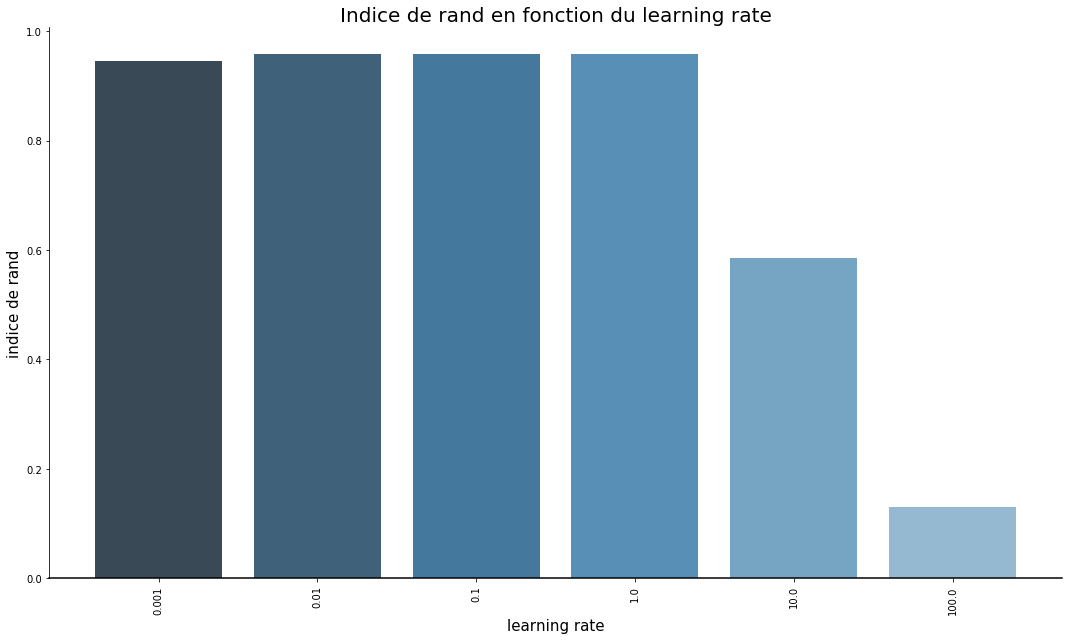

In [41]:
# ----------- CAS 3 CLUSTERS ------------

# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes

g = sns.barplot(x=lr, y=rands, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("learning rate",fontsize=15)
ax1.set_ylabel("indice de rand",fontsize=15)
#plt.axis([0, 365, 0, 40])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("Indice de rand en fonction du learning rate",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_commandes_utilisateurs.png', dpi=400)

In [42]:
print (rands)

[0.9452347100224571, 0.9587422838638878, 0.9587422838638878, 0.9587422838638878, 0.5850339795572596, 0.13112199989084075]


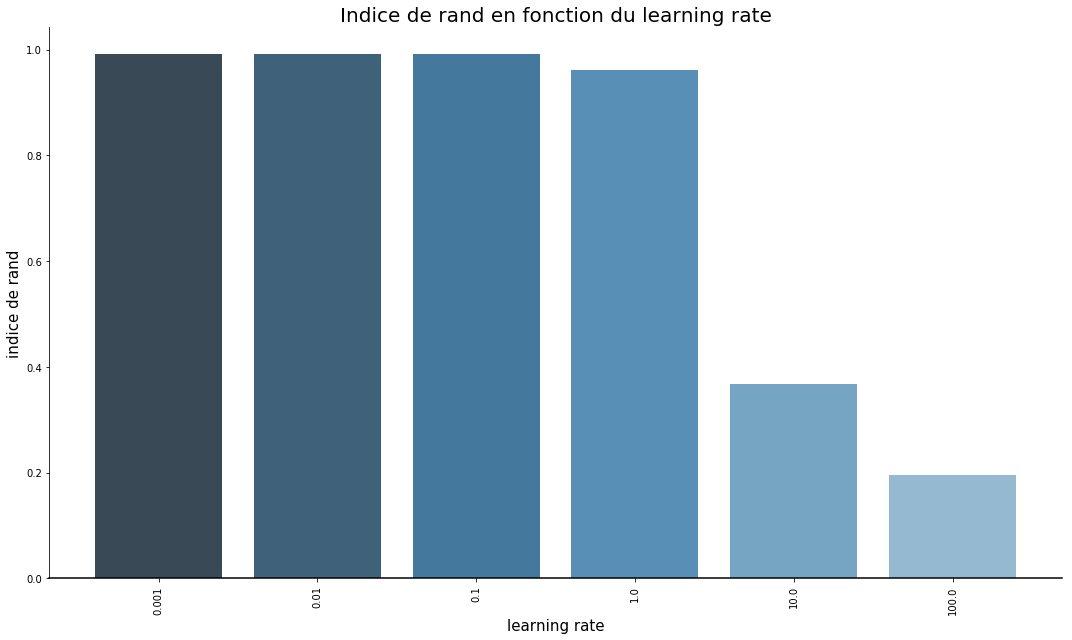

In [58]:
# ----------- CAS 9 CLUSTERS ------------

# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes

g = sns.barplot(x=lr, y=acc_scores, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("learning rate",fontsize=15)
ax1.set_ylabel("indice de rand",fontsize=15)
#plt.axis([0, 365, 0, 40])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("accuracy en fonction du learning rate",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_commandes_utilisateurs.png', dpi=400)

In [60]:
print (acc_scores)
print (rands)

[0.9924812030075187, 0.9915413533834586, 0.9915413533834586, 0.9624060150375939, 0.3684210526315789, 0.19548872180451127]
[0.9927695636572829, 0.9932708217033591, 0.9932708217033591, 0.962309358562006, 0.25592961691693056, 0.6079249659476231]


# Etude de la prédiction en fonction du nombre de premières commandes 


In [122]:
# liste des différents indices
rands = []
acc_scores = []

clusters = 3

dict_accur = dict()  

for t in range (4):
    print (t)
    
    # jeu de test en vue de la classification (imputé de certaines transactions)
    
    df_work = delete_t_value(df=df_test,t=t+2)   

    X_test = df_work.copy()
    X_test = features(X_test,t=1)

    # créer les vecteurs numpy
    X_test = np.matrix(X_test.iloc[:,1::])

    X_test = QT.transform(X_test) 

   
    # test knn 
    X_test_knn = df_work.copy()
    X_test_knn = features_knn(X_test_knn,ind=1)

    # tenseur numpy
    X_test_knn = np.matrix(X_test_knn.iloc[:,1::]) 

    # rescaling
    X_test_knn = QT_kn.transform(X_test_knn)

    # prédire avec le knn 

    labels_predict = neigh.predict(X_test_knn)

    # prédiction sur le jeux de test (random forest)

    y_predict = clf.predict(X_test)

    # vp fp vn fn
    accur = accuracy(label_true=labels_predict,label_predict=y_predict,clusters=clusters) 

    # enregistrer l'indice de rand normalisé 
    rand = adjusted_rand_score(labels_true=labels_predict,labels_pred=y_predict)
    
    acc_score = accuracy_score(y_true=labels_predict, y_pred=y_predict)

    rands.append(rand)
    acc_scores.append(acc_score)


    # créer le dictionnaire 
    if (t == 0):
            dict_accur = {'accur{}'.format(t):accur
                }

    #ajouter au dictionnaire
    if (t != 0):    

        dict_accur.update({'accur{}'.format(t):accur
                       }) 





0


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 


1
2
3


In [106]:
print (rands)

[0.6993299470915695, 0.7880404636285506, 0.9806674663789654, 1.0]


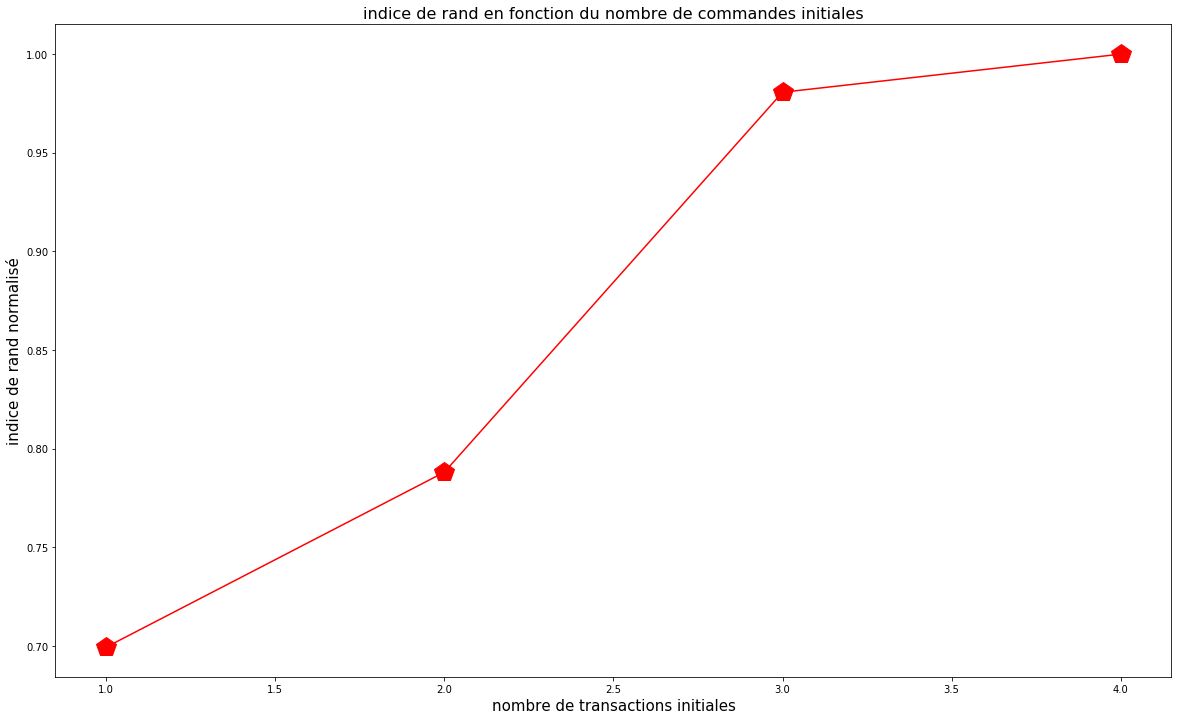

In [108]:
a = np.zeros(4)    

for i in range (4):
    a[i] = i + 1
    
    
# visualisation des coeficients 
f, (ax1) = plt.subplots(1, 1, figsize=(20, 12), sharex=True)

plt.title("indice de rand en fonction du nombre de commandes initiales",fontsize=16)

ax1.set_ylabel("indice de rand normalisé",fontsize=15)
ax1.set_xlabel("nombre de transactions initiales",fontsize=15)

plt.plot(a[:], rands[:],'p', markersize=20, c='red')
plt.plot(a[:], rands[:],'-', markersize=12, c='red')

In [174]:
a = dict_accur['accur0']
a = a.sort_values(by=['fp'])
b = dict_accur['accur1']
b = b.sort_values(by=['fp'])
c = dict_accur['accur2']
c = c.sort_values(by=['fp'])
d = dict_accur['accur3']
d = c.sort_values(by=['fp'])

In [172]:
list_vp = [np.sum(a.loc[:,'vp'])/4,np.sum(b.loc[:,'vp'])/4,np.sum(c.loc[:,'vp'])/4,np.sum(d.loc[:,'vp'])/4]
list_fp = [np.sum(a.loc[:,'fp'])/4,np.sum(b.loc[:,'fp'])/4,np.sum(c.loc[:,'fp'])/4,np.sum(d.loc[:,'fp'])/4]
list_vn = [np.sum(a.loc[:,'vn'])/4,np.sum(b.loc[:,'vn'])/4,np.sum(c.loc[:,'vn'])/4,np.sum(d.loc[:,'vn'])/4]
list_fn = [np.sum(a.loc[:,'fn'])/4,np.sum(b.loc[:,'fn'])/4,np.sum(c.loc[:,'fn'])/4,np.sum(d.loc[:,'fn'])/4]

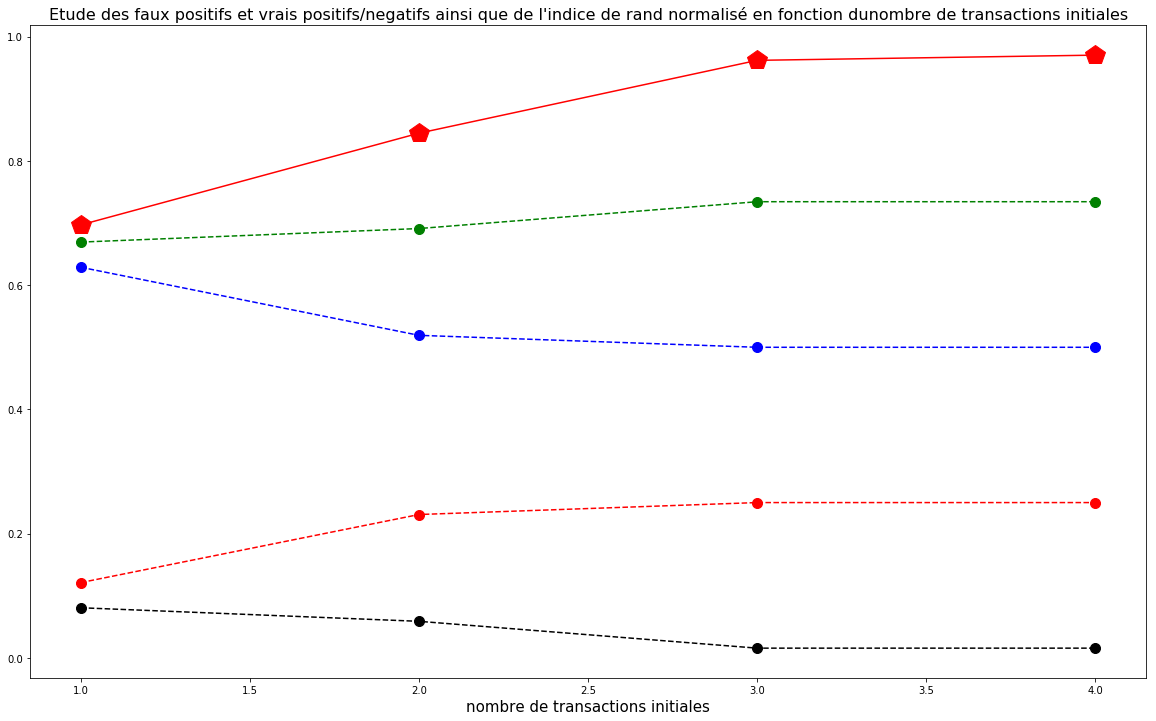

In [173]:
a = np.zeros(4)    

for i in range (4):
    a[i] = i + 1
    
    
# visualisation des coeficients 
f, (ax1) = plt.subplots(1, 1, figsize=(20, 12), sharex=True)

plt.title("Etude des faux positifs et vrais positifs/negatifs ainsi que de l'indice de rand normalisé en fonction du"
        "nombre de transactions initiales",fontsize=16)

#ax1.set_ylabel("indice de rand normalisé",fontsize=15)
ax1.set_xlabel("nombre de transactions initiales",fontsize=15)

plt.plot(a[:], list_vp[:],'ro', markersize=10, c='blue')
plt.plot(a[:], list_vp[:],'--', markersize=5, c='blue')
plt.plot(a[:], list_fp[:],'ro', markersize=10, c='red')
plt.plot(a[:], list_fp[:],'--', markersize=5, c='red')
plt.plot(a[:], list_vn[:],'ro', markersize=10, c='green')
plt.plot(a[:], list_vn[:],'--', markersize=5, c='green')
plt.plot(a[:], list_fn[:],'ro', markersize=10, c='black')
plt.plot(a[:], list_fn[:],'--', markersize=5, c='black')
plt.plot(a[:], rands[:],'p', markersize=20, c='red')
plt.plot(a[:], rands[:],'-', markersize=12, c='red')

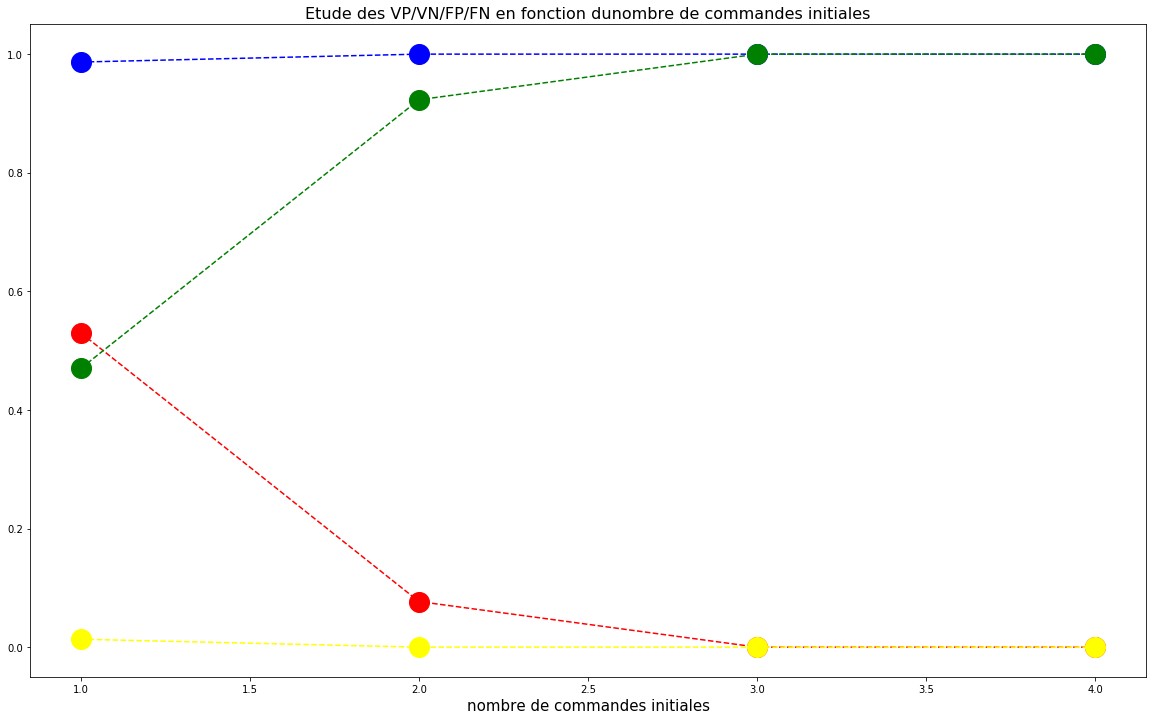

In [175]:
list_vp0 = [a.iloc[1,0],b.iloc[1,0],c.iloc[1,0],d.iloc[1,0]]
list_vp1 = [a.iloc[2,0],b.iloc[2,0],c.iloc[2,0],d.iloc[2,0]]


list_vn0 = [a.iloc[1,2],b.iloc[1,2],c.iloc[1,2],d.iloc[1,2]]
list_vn1 = [a.iloc[2,2],b.iloc[2,2],c.iloc[2,2],d.iloc[2,2]]


list_fp0 = [a.iloc[1,1],b.iloc[1,1],c.iloc[1,1],d.iloc[1,1]]
list_fp1 = [a.iloc[2,1],b.iloc[2,1],c.iloc[2,1],d.iloc[2,1]]

list_fn0 = [a.iloc[1,3],b.iloc[1,3],c.iloc[1,3],d.iloc[1,3]]
list_fn1 = [a.iloc[2,3],b.iloc[2,3],c.iloc[2,3],d.iloc[2,3]]


a = np.zeros(4)    

for i in range (4):
    a[i] = i + 1
    
    
# visualisation des coeficients 
f, (ax1) = plt.subplots(1, 1, figsize=(20, 12), sharex=True)

plt.title("Etude des VP/VN/FP/FN en fonction du"
        "nombre de commandes initiales",fontsize=16)



#ax1.set_ylabel("indice de rand normalisé",fontsize=15)
ax1.set_xlabel("nombre de commandes initiales",fontsize=15)


plt.plot(a[:], list_vn1[:],'ro', markersize=20, c='blue')
plt.plot(a[:], list_vn1[:],'--', markersize=8, c='blue')
plt.plot(a[:], list_vp1[:],'ro', markersize=20, c='red')
plt.plot(a[:], list_vp1[:],'--', markersize=8, c='red')
plt.plot(a[:], list_fp1[:],'ro', markersize=20, c='green')
plt.plot(a[:], list_fp1[:],'--', markersize=8, c='green')
plt.plot(a[:], list_fn1[:],'ro', markersize=20, c='yellow')
plt.plot(a[:], list_fn1[:],'--', markersize=8, c='yellow')

#plt.plot(a[:], list_vn0[:],'ro', markersize=20, c='blue')
#plt.plot(a[:], list_vn0[:],'-', markersize=8, c='blue')
#plt.plot(a[:], list_vp0[:],'ro', markersize=20, c='red')
#plt.plot(a[:], list_vp0[:],'-', markersize=8, c='red')
#plt.plot(a[:], list_fp0[:],'ro', markersize=20, c='green')
#plt.plot(a[:], list_fp0[:],'-', markersize=8, c='green')
#plt.plot(a[:], list_fn0[:],'ro', markersize=20, c='yellow')
#plt.plot(a[:], list_fn0[:],'-', markersize=8, c='yellow')


# Score en fonction du nombre de commandes initiales : entrainement sur 6 mois et test sur les 6 mois suivants


In [109]:
# APPRENTISSAGE SUPERVISE ------------------------pour 3 clusters------------------------------------

# ouvrir les données 

# ouvrir les données 

df_test = pd.read_csv('df_test2.csv')
df_test.loc[:,'InvoiceDate'] = pd.to_datetime(df_test.InvoiceDate,errors='coerce')


# ouvrir les données 

df_train = pd.read_csv('df_train2.csv')
df_train.loc[:,'InvoiceDate'] = pd.to_datetime(df_train.InvoiceDate,errors='coerce')



# liste des indices de rand
rands = []

# importer la carte des labels 
map1= pd.read_csv('user_labeln2.csv')



for i in range (map1.shape[0]):
    a = map1.iloc[i,2]
    map1.iloc[i,2] = int(a[2])
    
# appliquer les features du le jeux d'entrainement (en vue de la classification)

X_train = df_train.copy() 
X_train = features(X_train,t=1)

# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train = X_train.sort_values(by=['CustomerID'])    

# créer les vecteurs numpy
X_train = np.matrix(X_train.iloc[:,1::])


# rescaling features

QT = QuantileTransformer(output_distribution='normal').fit(X_train)
X_train = QT.transform(X_train)  

# jeu de test en vue de la classification

X_test = df_test.copy()  
X_test = features(X_test,t=1)

# créer les vecteurs numpy
X_test = np.matrix(X_test.iloc[:,1::])

X_test = QT.transform(X_test) 

# entrainement du knn 

X_train_knn = features_knn(df_train,ind=1)

# test knn 

X_test_knn = features_knn(df_test,ind=1)

# trier les jeux de données 
map1_t = map1.sort_values(by=['user'])

X_train_knn = X_train_knn.sort_values(by=['CustomerID'])  


# tenseur numpy
X_test_knn = np.matrix(X_test_knn.iloc[:,1::]) 

# tenseur numpy
X_train_knn = np.matrix(X_train_knn.iloc[:,1::]) 


# fit sur les données d'entrainement
QT_kn = QuantileTransformer(output_distribution='normal').fit(X_train_knn)

# rescaling
X_test_knn = QT_kn.transform(X_test_knn)

# rescaling
X_train_knn = QT_kn.transform(X_train_knn)


# entrainner le knn      

neigh = KNeighborsClassifier(n_neighbors=1)

neigh.fit(X_train_knn, map1_t.iloc[:,2])

# prédire avec le knn 

labels_predict = neigh.predict(X_test_knn)

        
# créer le modèle de forêt aléatoire
clf = RandomForestClassifier(n_estimators= 3000, max_depth=6,
                                random_state=0)

# entrainer ce modèle
clf.fit(X_train,map1_t.loc[:,'label'])
    
# prédiction sur le jeux de test 

y_predict = clf.predict(X_test)

# enregistrer l'indice de rand normalisé 
rand = adjusted_rand_score(labels_true=labels_predict,labels_pred=y_predict)
print ('rand')    
print (rand)

clusters = 3

dict_accur = dict()  

for t in range (4):
    print (t)
    
    # jeu de test en vue de la classification (imputé de certaines transactions)
    
    df_work = delete_t_value(df=df_test,t=t+2) 
    print (df_work.shape)

    X_test = df_work.copy()
    X_test = features(X_test,t=1)

    # créer les vecteurs numpy
    X_test = np.matrix(X_test.iloc[:,1::])

    X_test = QT.transform(X_test) 

   
    # test knn 
    X_test_knn = df_work.copy()
    X_test_knn = features_knn(X_test_knn,ind=1)

    # tenseur numpy
    X_test_knn = np.matrix(X_test_knn.iloc[:,1::]) 

    # rescaling
    X_test_knn = QT_kn.transform(X_test_knn)

    # prédire avec le knn 

    labels_predict = neigh.predict(X_test_knn)

    # prédiction sur le jeux de test (random forest)

    y_predict = clf.predict(X_test)


    # enregistrer l'indice de rand normalisé 
    rand = adjusted_rand_score(labels_true=labels_predict,labels_pred=y_predict)

    rands.append(rand)   



C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 


rand
0.9448953576810896
0
(22441, 14)


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 


1
(18757, 14)
2
(16137, 14)
3
(13159, 14)


In [110]:
rands

[0.7076083392093947, 0.8723137246335656, 0.9621571922158345, 1.0]

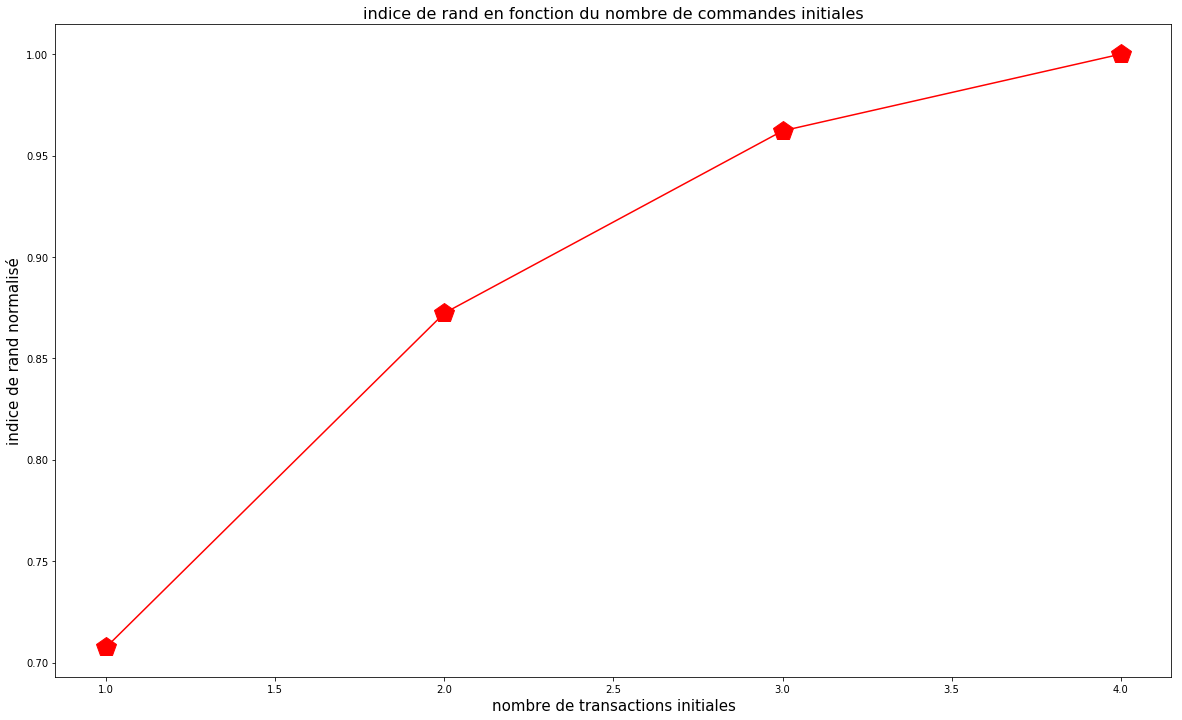

In [111]:
a = np.zeros(4)    

for i in range (4):
    a[i] = i + 1
    
    
# visualisation des coeficients 
f, (ax1) = plt.subplots(1, 1, figsize=(20, 12), sharex=True)

plt.title("indice de rand en fonction du nombre de commandes initiales",fontsize=16)

ax1.set_ylabel("indice de rand normalisé",fontsize=15)
ax1.set_xlabel("nombre de transactions initiales",fontsize=15)

plt.plot(a[:], rands[:],'p', markersize=20, c='red')
plt.plot(a[:], rands[:],'-', markersize=12, c='red')

# Prédiction 

On utilise nos modèles de classification entrainés pour prédire, suite à au moins une commande utilisateur, le cluster d'appartenance final de l'utilisateur

In [2]:
# créer des utilisateurs test : 

df = pd.read_csv('fc_data.csv')
df.loc[:,'InvoiceDate'] = pd.to_datetime(df.InvoiceDate,errors='coerce')

In [5]:
valeurs_cust = plot_value_counts('CustomerID',df=df)
valeurs_cust = valeurs_cust.sort_values(by=['CustomerID'])
df_test = df[df.loc[:,'CustomerID'] == valeurs_cust.iloc[252,0]]
 
df_test

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_bis
3087,328697,565801,N23203,JUMBO BAG VINTAGE DOILY,20,2011-09-07 10:28:00,2.08,N12685.0,France,Foreign
3821,459848,575884,N23203,JUMBO BAG VINTAGE DOILY,10,2011-11-11 13:46:00,2.08,N12685.0,France,Foreign
5475,330904,565930,N23213,STAR WREATH DECORATION WITH BELL,12,2011-09-08 10:32:00,1.25,N12685.0,France,Foreign
11296,459850,575884,N21135,VICTORIAN METAL POSTCARD SPRING,8,2011-11-11 13:46:00,1.69,N12685.0,France,Foreign
15780,394716,570879,N22727,ALARM CLOCK BAKELIKE RED,12,2011-10-13 08:42:00,3.75,N12685.0,France,Foreign
17024,330895,565930,N23241,TREASURE TIN GYMKHANA DESIGN,6,2011-09-08 10:32:00,2.08,N12685.0,France,Foreign
22987,328702,565801,N21424,WOODLAND STORAGE BOX LARGE,6,2011-09-07 10:28:00,2.95,N12685.0,France,Foreign
23418,407991,571923,N85014B,RED RETROSPOT UMBRELLA,3,2011-10-19 16:24:00,5.95,N12685.0,France,Foreign
26940,330886,565930,N22727,ALARM CLOCK BAKELIKE RED,4,2011-09-08 10:32:00,3.75,N12685.0,France,Foreign
29898,459858,575884,N23109,PACK OF SIX LED TEA LIGHTS,6,2011-11-11 13:46:00,2.89,N12685.0,France,Foreign


In [6]:
t = 1

In [7]:
# fonction engendrant les caractéristiques necesaires à la ségmentation des modèles 1 

# importer les informations de popularité des items
valeurs_items = pd.read_csv('valeurs_items.csv')

df = df_test
df.loc[:,'InvoiceDate'] = pd.to_datetime(df.InvoiceDate,errors='coerce')

ind_date = df.columns.get_loc('InvoiceDate')
df['DAY'] = df.iloc[:,ind_date].dt.dayofyear
df['HOUR'] = df.iloc[:,ind_date].dt.hour
df['MONTH'] = df.iloc[:,ind_date].dt.month
 


# repérer les indices    

ind_price = df.columns.get_loc('UnitPrice')    
ind_q = df.columns.get_loc('Quantity')
ind_cbis = df.columns.get_loc('Country_bis')  

    
# ---------------------------------------- Associer les caractéristiques moyennes ------------------------------------
if (t>0):
   
    #creer le dataset "dataset_clust"
    d = {'user':['new_user'],'nb_unit':[0],'prix_unit':[0],'montant':[0],
         'pays':[0],'nb_produit_diff':[0],'nb_commandes':[0],'nb_produit_id':[0],'frequence':[0],'jourmax':[0],'heuremax':[0],
         'jourprob':[0],'heureprob':[0],'pop1':[0],'pop2':[0]
        }
    dataset_clust = pd.DataFrame(data=d)
    
if (t==0):
    #creer le dataset "dataset_clust"
    d = {'user':['new_user'],'nb_unit':[0],'prix_unit':[0],'montant':[0],
         'pays':[0],'nb_produit_diff':[0],'nb_commandes':[0],'jourmax':[0],'heuremax':[0],
         'jourprob':[0],'heureprob':[0],'pop1':[0],'pop2':[0]
        }
    dataset_clust = pd.DataFrame(data=d)

# associer la valeur 1 lorsque le pays est uk et 0 sinon
df['Country_bis'][df.loc[:,'Country_bis'] == 'UK'] = 1
df['Country_bis'][df.loc[:,'Country_bis'] == 'Foreign'] = 0

#----------------------------------------------------------------------------------

# remplir les colonnes

df_trans =  df    


dataset_clust.loc[0,'nb_unit'] = np.mean(df_trans.iloc[:,ind_q])
dataset_clust.loc[0,'prix_unit'] = np.mean(df_trans.iloc[:,ind_price])
dataset_clust.loc[0,'montant'] = np.mean(df_trans.iloc[:,ind_price].multiply(df_trans.iloc[:,ind_q]))
dataset_clust.loc[0,'pays'] = df_trans.iloc[0,ind_cbis]

valeurs_invoice = plot_value_counts('InvoiceNo',df=df)
dataset_clust.loc[0,'nb_produit_diff'] = np.mean(valeurs_invoice.iloc[:,1])
dataset_clust.loc[0,'nb_commandes'] = valeurs_invoice.shape[0]

valeurs_identiques = plot_value_counts('StockCode',df=df)
if (t>0):
    
    dataset_clust.loc[0,'nb_produit_id'] = np.mean(valeurs_identiques.iloc[:,1]) 

    dataset_clust.loc[0,'frequence'] = (np.amax(df_trans.loc[:,'InvoiceDate']) - 
                                                np.amin(df_trans.loc[:,'InvoiceDate']))/df_trans.shape[0]


    dataset_clust.loc[0,'frequence'] = dataset_clust.loc[0,'frequence'].total_seconds()
    dataset_clust.loc[0,'frequence'] = float(dataset_clust.loc[0,'frequence'])

valeurs_day = plot_value_counts('DAY',df=df_trans)
valeurs_day.iloc[:,0] = pd.to_numeric(valeurs_day.iloc[:,0], errors='coerce').fillna(0, downcast='infer')  
        
dataset_clust.loc[0,'jourmax'] = valeurs_day.iloc[0,0]
dataset_clust.loc[0,'heuremax'] = valeurs_day.iloc[0,1]/np.sum(valeurs_day.iloc[0,:])

valeurs_hour = plot_value_counts('HOUR',df=df_trans)
valeurs_hour.iloc[:,0] = pd.to_numeric(valeurs_hour.iloc[:,0], errors='coerce').fillna(0, downcast='infer') 

dataset_clust.loc[0,'jourprob'] = valeurs_hour.iloc[0,0] 
dataset_clust.loc[0,'heureprob'] = valeurs_hour.iloc[0,1]/np.sum(valeurs_hour.iloc[0,:])

# popularité 
# considérer les items communs entre valeurs_items et valeurs_identiques
valeurs_pop = valeurs_items[(valeurs_items.loc[:,'StockCode'].isin(valeurs_identiques.iloc[:,0]))].reset_index(drop=True)
# le score de popularité utilisateur est la moyenne des scores items 
dataset_clust.loc[0,'pop1'] = np.mean(valeurs_pop.loc[:,'pop1'])
dataset_clust.loc[0,'pop2'] = np.mean(valeurs_pop.loc[:,'pop2'])

 
    
df_manual2 = dataset_clust

# remplacer les "nan" par des 0

df_manual2 = dataset_clust.fillna(0)


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# -------- pour 3 clusters -------------
# ouvrir les informations relatives au modèle 
clf = joblib.load('model')

inter = pd.read_csv('cluster_annotN3.csv')
    
user = np.matrix(df_manual2.iloc[:,1::])

QT.transform(user) 
    
labels_predict = clf.predict(user)    

inter = inter[inter.loc[:,'cluster_num']==labels_predict[0]]
print ("L'utilisateur dont vous avez rentré les informations est suceptible d'appartenir au cluster {}.".format(labels_predict[0]))
print ("caractéristiques du cluster {}: {}".format(labels_predict[0],inter.iloc[0,2]))

L'utilisateur dont vous avez rentré les informations est suceptible d'appartenir au cluster 2.
caractéristiques du cluster 2: Montants plutôt élevés, de clients possiblement étrangers, en plutôt grande quantité, assez irrégulières, de produits plutôt rares avec peu de transactions redondantes 
